In [1]:
import numpy as np 
import mdtraj as md
from molecular_mpns.config import data_dir, fig_dir
from molecular_mpns.vae import VAE, VAEloss
from molecular_mpns.data import AlanineDipeptideGraph
from torch_geometric.data import DataLoader
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ExponentialLR
import os

In [2]:
# load training trajectory
os.chdir(data_dir)
os.chdir('alanine_dipeptide/')
xtc_file = 'alanine-dipeptide-0-250ns-nowater.xtc'
top_file = 'alanine-dipeptide-nowater.pdb'
traj = md.load(xtc_file,top=top_file)

In [3]:
# create graphs
batch_size = 32
z = [atom.element.atomic_number for atom in traj.topology.atoms]
G = [AlanineDipeptideGraph(z = torch.tensor(z).long(),pos = torch.tensor(xyz)) for xyz in traj.xyz]

In [4]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_spherical, num_radial, hidden_channels, num_bilinear, out_channels, num_layers, cutoff= 16, 6, 128, 4, 64, 2, 0.5
mod = VAE(num_spherical, num_radial, hidden_channels, num_bilinear, out_channels, num_layers, cutoff)
mod = mod.to(device)

opt = torch.optim.Adam(mod.parameters(),lr = 1e-7, weight_decay = 1e-5)
sched = ExponentialLR(opt, gamma = 0.995)

Epoch 1 Loss: 6446.224914550781


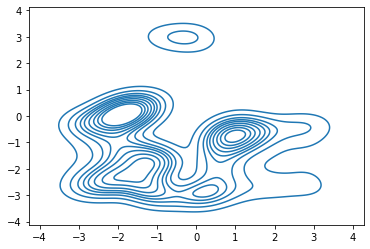

Epoch 2 Loss: 6456.311492919922


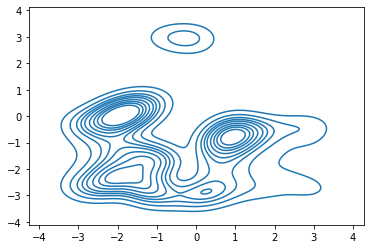

Epoch 3 Loss: 6437.970642089844


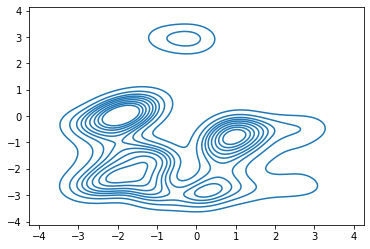

Epoch 4 Loss: 6453.249603271484


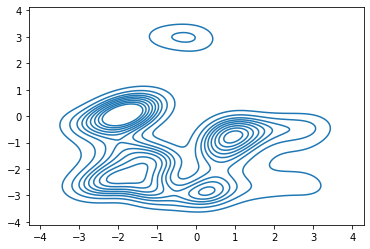

Epoch 5 Loss: 6456.370361328125


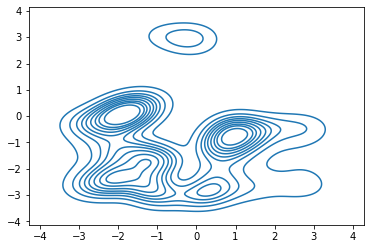

Epoch 6 Loss: 6446.248077392578


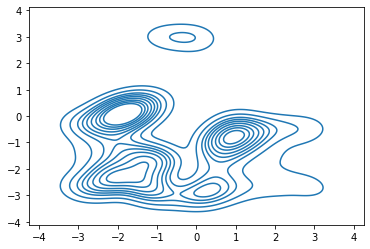

Epoch 7 Loss: 6461.3082275390625


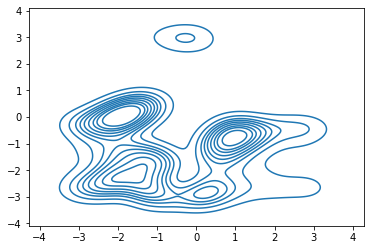

Epoch 8 Loss: 6458.8172607421875


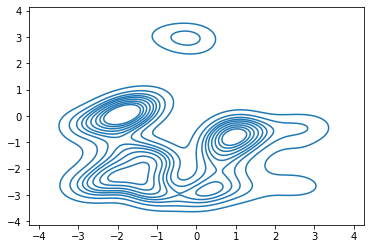

Epoch 9 Loss: 6444.910430908203


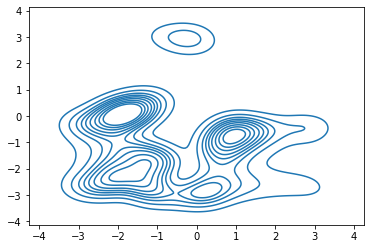

Epoch 10 Loss: 6448.564208984375


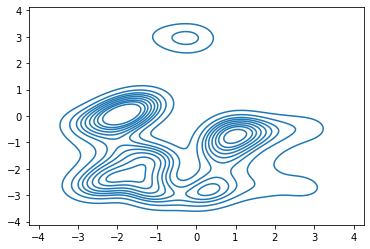

Epoch 11 Loss: 6439.7294921875


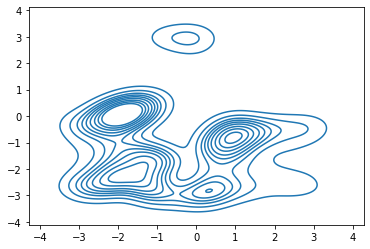

Epoch 12 Loss: 6444.506530761719


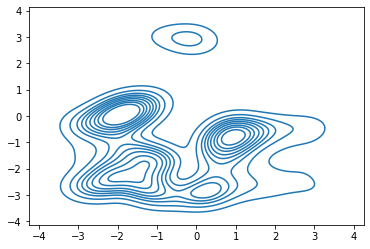

Epoch 13 Loss: 6455.7413330078125


KeyboardInterrupt: 

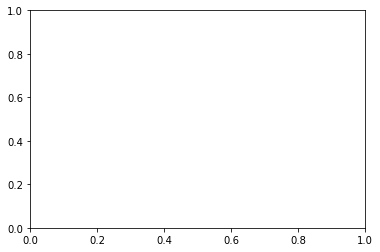

In [5]:
# training loop
os.chdir(fig_dir)
epochs, batch_size = 25, 32

for ep in range(epochs):
    ep_loss = 0
    
    # downsample training set
    random_idx = np.random.choice(len(G),100, replace = False)
    G_epoch = [G[i] for i in random_idx]
    loader = DataLoader(G_epoch,batch_size = batch_size)
    
    for G_batch in loader:
        G_batch.to(device)
        
        # forward pass
        recon_batch, mu_enc, logvar_enc = mod(G_batch)
        mu_dec = recon_batch[0]
        logvar_dec = recon_batch[1]
        
        # compute loss
        loss = VAEloss(mu_dec,logvar_dec,G_batch,mu_enc,logvar_enc,L=1)
        
        # back prop
        loss.backward()
        opt.step()
        opt.zero_grad()
        ep_loss += loss.item()
    
    if (ep+1) % 1 == 0:
    
        print("Epoch " + str(ep + 1) + " Loss: " + str(ep_loss))
        
        val_size = 4000
        
        z = torch.randn((val_size,2))
        with torch.no_grad():
            x_recon, _ = mod.decode(z.to(device))
        
        x_np = x_recon.cpu().numpy()
        x_np = x_np.reshape((val_size,22,3))
        val_traj = md.Trajectory(xyz = x_np,topology = traj.topology)
        psi_inds, phi_inds = [6, 8, 14, 16], [4, 6, 8, 14]
        dihedrals = md.compute_dihedrals(val_traj,[psi_inds,phi_inds])  
        
        #plt.scatter(dihedrals[:,1],dihedrals[:,0],s = 1)
        sns.kdeplot(dihedrals[:,1],y = dihedrals[:,0])
        
        #plt_filename = 'dih_recon'+str(ep)+'.png'
        #plt.savefig(plt_filename)
        
        plt.show()
        plt.close()